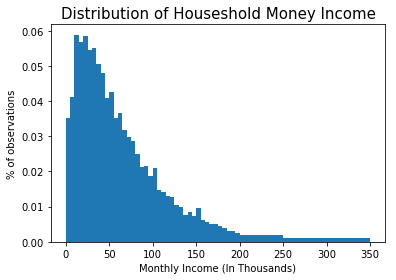

In [87]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import integrate as intgr
from numpy import linalg as la

filename = '/Users/bryanchia/Desktop/BootCamp2017/ProbSets/Econ/Wk4_StrEst/data/usincmoms.txt'

data = []
with open(filename) as inputfile:
    for line in inputfile:
        data.append(line.strip().split('\t'))

data = np.asarray(data)
data = data.astype(float)
data_plot = data[:,1] / 1000

weights = np.copy(data[:,0])
weights_adj = np.copy(weights)
weights_adj[-2] /= 10
weights_adj[-1] /= 20
bracket = data[:,1] / 1000

#Part A

bin_edge = np.arange(0, 205, 5)
bin_edge = np.append(bin_edge, [250, 350])

plt.hist(data_plot,bins = bin_edge, weights = weights_adj)
plt.title('Distribution of Houseshold Money Income', fontsize=15)
plt.xlabel(r'Monthly Income (In Thousands)')
plt.ylabel(r'% of observations')

plt.show()

In [70]:
# Part B

def lognorm_pdf(x, mu, sigma):
    
    denom1 = x * sigma * np.sqrt(2 * np.pi)
    if np.isclose(denom1, 0, atol = 1e-25):
        denom1 = 1e-24
    
    denom2 = 2 * sigma ** 2
    if np.isclose(denom2, 0, atol = 1e-25):
        denom2 = 1e-24
    
    exponent1 = - ((np.log(x) - mu) ** 2) / (2 * sigma ** 2)
    if np.isclose(exponent1, 0, atol = 1e-25):
        exponent1 = 1e-24
        
    #exponent1 = 1
    
    pdf_vals = (1 / denom1) * np.exp(exponent1)
    
    return pdf_vals 

def data_moments4(data):
    data_mom = data
    return data_mom

left = bin_edge[:-1]
right = bin_edge[1:]
n = len(data)

def model_moments4(mu, sigma):
    fx = lambda x: stats.lognorm.cdf(x, sigma, scale = np.exp(mu))
    mod_mom = np.empty(n)
    for i in range(n):
        if i == n-1:
            mod_mom[i] = fx(np.inf) - fx(left[-1])
        else:
            mod_mom[i] = fx(right[i]) - fx(left[i])
    return mod_mom

def err_vec4(xvals, mu, sigma, simple):

    moms_data = data_moments4(xvals)
    moms_model = model_moments4(mu, sigma)

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion4(params, *args):

    mu, sigma = params
    xvals, W = args
    err = err_vec4(xvals, mu, sigma, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

mu_init = np.log(np.sum(bracket * weights))
sig_init = 5
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(weights)
gmm_args = (weights, W_hat)
results_4 = opt.minimize(criterion4, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_4, sig_GMM1_4 = results_4.x
print('Mu hat =', mu_GMM1_4, ' Sigma hat =', sig_GMM1_4, 'Criterion Function = ', -results_4.fun)

Mu hat = 3.90970827269  Sigma hat = 0.954698952366 Criterion Function =  -5.4228694557e-05


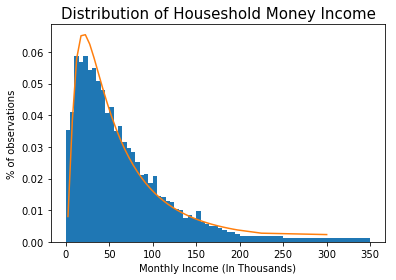

In [88]:
moments_ln = np.zeros((len(left)))
fxln = lambda x: stats.lognorm.cdf(x, sig_GMM1_4, scale = np.exp(mu_GMM1_4))
for i in range(n):
    if i == n-1:
        moments_ln[i] = fxln(np.inf) - fxln(left[-1])
    else:
        moments_ln[i] = fxln(right[i]) - fxln(left[i])
moments_ln[-1] /= 20
moments_ln[-2] /= 10
plt.title('Distribution of Houseshold Money Income', fontsize=15)
plt.xlabel(r'Monthly Income (In Thousands)')
plt.ylabel(r'% of observations')
plt.hist(data_plot,bins = bin_edge, weights = weights_adj)
plt.plot(bracket, moments_ln)
plt.show()

In [77]:
def gamma_pdf(xvals, alpha, beta):

    pdf_vals = (1 / ((beta ** alpha) * sp.special.gamma(alpha))) * xvals ** (alpha - 1) * np.exp (-xvals / beta)
    if np.isclose(pdf_vals, 0, atol = 1e-25):
        pdf_vals = 1e-24
    #pdf_vals[np.isclose(pdf_vals, np.zeros_like(pdf_vals), atol = 1e-25)] = 1e-24
    return pdf_vals

def data_moments5(data):
    data_mom = data
    return data_mom

left = bin_edge[:-1]
right = bin_edge[1:]
n = len(data)

def model_moments5(alpha, beta):
    fx = lambda x: stats.gamma.cdf(x, alpha, scale=beta)
    mod_mom = np.empty(n)
    for i in range(n):
        if i == n-1:
            mod_mom[i] = fx(np.inf) - fx(left[-1])
        else:
            mod_mom[i] = fx(right[i]) - fx(left[i])
    return mod_mom

def err_vec5(xvals, alpha, beta, simple):

    moms_data = data_moments5(xvals)
    moms_model = model_moments5(alpha, beta)

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def criterion5(params, *args):

    alpha, beta = params
    xvals, W = args
    err = err_vec5(xvals, alpha, beta, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

percent = data[:,0]
beta_init = 20.0
alpha_init = 3.0
params_init = np.array([alpha_init, beta_init])
W_hat = np.diag(weights)
gmm_args = (weights, W_hat)
results_5 = opt.minimize(criterion5, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
alpha_GMM1_5, beta_GMM1_5 = results_5.x
print('Alpha hat =', alpha_GMM1_5, ' Beta hat =', beta_GMM1_5, 'Criterion Function = ', -results_5.fun)
print()

Alpha hat = 1.36182581621  Beta hat = 48.3618218466 Criterion Function =  -123.430462452



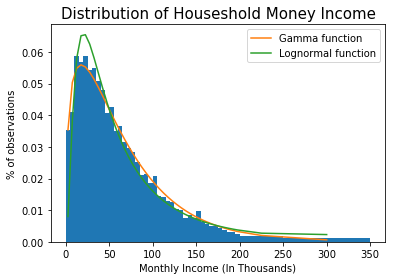

In [96]:
fx2 = lambda x: stats.gamma.cdf(x, alpha_GMM1_5, scale=beta_GMM1_5)
moments_gamma = np.zeros((len(left)))
for i in range(n):
    if i == n-1:
        moments_gamma[i] = fx2(np.inf) - fx2(left[-1])
    else:
        moments_gamma[i] = fx2(right[i]) - fx2(left[i])
moments_gamma[-1] /= 20
moments_gamma[-2] /= 10
plt.hist(data_plot, bins = bin_edge, weights = weights_adj)
plt.plot(bracket, moments_gamma, label = 'Gamma function')
plt.plot(bracket, moments_ln, label = 'Lognormal function')
plt.title('Distribution of Houseshold Money Income', fontsize=15)
plt.xlabel(r'Monthly Income (In Thousands)')
plt.ylabel(r'% of observations')
plt.legend(loc = 'upper right')
plt.show()

In [97]:
#Calcualting 2 step W hat matrix

err1 = err_vec5(bracket, alpha_GMM1_5, beta_GMM1_5, False)
err1 = err1.reshape(42,1)
VCV2 = np.dot(err1, err1.reshape(1,42)) / bracket.shape[0]

#Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
W_hat2 = la.pinv(VCV2)

In [100]:
beta_init = 20.0
alpha_init = 3.0
params_init = np.array([alpha_init, beta_init])
W_hat = W_hat2
gmm_args = (weights, W_hat)
results_5 = opt.minimize(criterion5, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM1_5, beta_GMM1_5 = results_5.x
print('Alpha hat =', alpha_GMM1_5, ' Beta hat =', beta_GMM1_5, 'Criterion Function = ', -results_5.fun)

Alpha hat = 3.4875741358  Beta hat = 20.0877443782 Criterion Function =  -9.19612848612e-13


One possible way of comparison would be to look at the Log-likelihood values. Since the 2 step weighting matrix has a much lower log-likelihood value, it must provide a better fit.

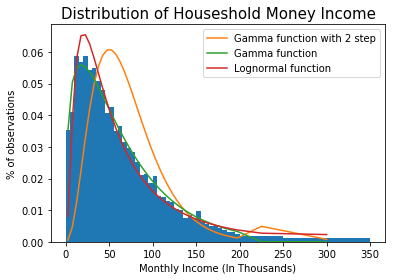

In [102]:
fx2 = lambda x: stats.gamma.cdf(x, alpha_GMM1_5, scale=beta_GMM1_5)
moments_gamma1 = np.zeros((len(left)))
for i in range(n):
    if i == n-1:
        moments_gamma1[i] = fx2(np.inf) - fx2(left[-1])
    else:
        moments_gamma1[i] = fx2(right[i]) - fx2(left[i])
moments_gamma[-1] /= 20
moments_gamma[-2] /= 10
plt.hist(data_plot, bins = bin_edge, weights = weights_adj)
plt.plot(bracket, moments_gamma1, label = 'Gamma function with 2 step')
plt.plot(bracket, moments_gamma, label = 'Gamma function')
plt.plot(bracket, moments_ln, label = 'Lognormal function')
plt.title('Distribution of Houseshold Money Income', fontsize=15)
plt.xlabel(r'Monthly Income (In Thousands)')
plt.ylabel(r'% of observations')
plt.legend(loc = 'upper right')
plt.show()

But the graph doesn't look like it fits that well...